# Sarsa, Q-learning and Expected Sarsa
<b>Gabriele Prato, McGill University</b>

In this notebook, we will be implementing and comparing Sarsa, Q-learning and Expected Sarsa on the Cliff Walking problem described in the class textbook [1].

Example 6.6 will be implemented as well as the Sarsa, Q-learning and Expected Sarsa algorithms.

## Libraries and Modules

In [1]:
!pip install ipythonblocks

In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from ipythonblocks import BlockGrid
from IPython.display import clear_output
from sets import Set

/Users/prato/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: the sets module is deprecated


## Example 6.6: Cliff Walking

The following environment is the same as the one described in the textbook [1]. As is the case with other Gridworlds exercices, the agent cannot leave the grid. He can waste an action trying to move outside of it, but he will stay in the same state or "position" as before the action, of course receiving a negative reward of -1.

In [2]:
class TheCliff:
    def __init__(self):
        self.state = [0, 0]
        self.GOAL = [0, 11]
        self.MAX_ROW = 3
        self.MAX_COLUMN = 11
        
    def takeAction(self, action):
        self.state += action
        
        if self.state[0] == 0 and 1 <= self.state[1] <= 10:
            self.state = [0, 0]
            return -100
        
        self.adjustStateIfOutsideGrid() # Agent is not allowed outside the grid

        if np.array_equal(self.state, self.GOAL):
            return 0
        else:
            return -1
    
    def adjustStateIfOutsideGrid(self):
        if self.state[0] < 0:
            self.state[0] = 0
        elif self.state[0] > self.MAX_ROW:
            self.state[0] = self.MAX_ROW
            
        if self.state[1] < 0:
            self.state[1] = 0
        elif self.state[1] > self.MAX_COLUMN:
            self.state[1] = self.MAX_COLUMN
    
    def reset(self):
        self.state = [0, 0]
        
    # Displays the current state of the environment in a nice colored grid
    def view(self):
        gridHeight = self.MAX_ROW
        gridWidth = self.MAX_COLUMN
        
        grid = BlockGrid(self.MAX_COLUMN + 1, self.MAX_ROW + 1, fill=(224, 224, 224))
        grid[gridHeight, 1:11] = (170, 170, 170)
        grid[gridHeight - self.state[0], self.state[1]] = (0, 0, 0)
        grid[gridHeight - self.GOAL[0], self.GOAL[1]] = (255, 0, 0)
        
        grid.show()

In [3]:
environment = TheCliff()
environment.view()

,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,


Initial state of The Cliff. <br />
Agent: <span style="font-size:200%">■</span> &nbsp; 
Goal: <span style="color:red;font-size: 200%">■</span> &nbsp; 
Cliff: <span style="color:rgb(170, 170, 170);font-size: 200%">■</span> &nbsp; 
<hr/>
We will now implement the three algorithms (Sarsa, Q-learning and Expected Sarsa). The class ControlAlgorithm is the basis for all three algorithms. It has all the code used to run the core algorithm multiple times, average the statistics and view the learned policy. The three classes, Sarsa, QLearning, ExpectedSarsa, will only  contain the core algorithm.

In [4]:
class ControlAlgorithm:
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        self.Q = np.zeros((environment.MAX_ROW + 1, environment.MAX_COLUMN + 1, ACTIONS.shape[0]))
        self.environment = environment
        self.ALPHA = ALPHA
        self.DISCOUNT = DISCOUNT
        self.EPSILON = EPSILON
      
    def averageMSumOfRewardsOverNEpisodes(self, M, N):
        sumOfRewardsPerEpisode = np.zeros((M, N))
        for i in range(M):
            self.resetQ()
            
            for j in range(N):
                sumOfRewardsPerEpisode[i, j] = self.generateEpisode()
        
        return np.average(sumOfRewardsPerEpisode, axis=0)
    
    def averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(self, M, K, N):
        sumOfRewardsPerEpisode = np.zeros((M, N/K))
        for i in range(M):
            self.resetQ()
            
            kCounter = 0
            sumOfRewards = 0
            for j in range(N):
                sumOfRewards += self.generateEpisode()
                if j % K == K-1:
                    sumOfRewardsPerEpisode[i, kCounter] = sumOfRewards / K
                    sumOfRewards = 0
                    kCounter += 1
        
        return np.average(sumOfRewardsPerEpisode, axis=0)
    
    def resetQ(self):
        self.Q = np.zeros((self.environment.MAX_ROW + 1, self.environment.MAX_COLUMN + 1, ACTIONS.shape[0]))
    
    def chooseAction(self):
        if np.random.rand(1)[0] <= self.EPSILON:
            actionId = np.random.randint(ACTIONS.shape[0], size=1)[0]
        else:
            actionId = np.argmax(self.Q[self.environment.state[0], self.environment.state[1]])
            
            # If multiple actions have the same max value, we need to choose one of them randomly
            possibleActions = []
            for i in range(ACTIONS.shape[0]):
                if (self.Q[self.environment.state[0], self.environment.state[1], i] == 
                   self.Q[self.environment.state[0], self.environment.state[1], actionId]):
                    possibleActions.append(i)
                    
            actionId = random.choice(possibleActions)
        
        return ACTIONS[actionId], actionId
    
    # Displays the learned policy trying to complete an episode.
    def viewLearnedPolicy(self):
        self.environment.reset()
        self.environment.view()
        
        while not np.array_equal(self.environment.state, self.environment.GOAL):
            action, actionId = self.chooseAction()
            self.environment.takeAction(action)
            
            clear_output()
            self.environment.view()
            time.sleep(0.5)

In [5]:
class Sarsa(ControlAlgorithm):
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, environment, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.environment.reset()
        
        reward = 0
        sumOfRewards = 0

        action, actionId = self.chooseAction()
        
        while not np.array_equal(self.environment.state, self.environment.GOAL):
            previousState = np.copy(self.environment.state)
            reward = self.environment.takeAction(action)
            sumOfRewards += reward
        
            nextAction, nextActionId = self.chooseAction()
        
            self.Q[previousState[0], previousState[1], actionId] += self.ALPHA * (reward + 
                self.DISCOUNT * self.Q[self.environment.state[0], self.environment.state[1], nextActionId] - 
                self.Q[previousState[0], previousState[1], actionId])
            
            action = nextAction
            actionId = nextActionId
        
        return sumOfRewards

In [6]:
class Qlearning(ControlAlgorithm):
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, environment, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.environment.reset()
        
        reward = 0
        sumOfRewards = 0

        while not np.array_equal(self.environment.state, self.environment.GOAL):
            previousState = np.copy(self.environment.state)
            
            action, actionId = self.chooseAction()
            reward = self.environment.takeAction(action)
            sumOfRewards += reward
        
            self.Q[previousState[0], previousState[1], actionId] += self.ALPHA * (reward + 
                self.DISCOUNT * np.max(self.Q[self.environment.state[0], self.environment.state[1]]) - 
                self.Q[previousState[0], previousState[1], actionId])
        
        return sumOfRewards

In [7]:
class ExpectedSarsa(ControlAlgorithm):
    def __init__(self, environment, ALPHA, DISCOUNT, EPSILON):
        ControlAlgorithm.__init__(self, environment, ALPHA, DISCOUNT, EPSILON)
        
    def generateEpisode(self):
        self.environment.reset()
        
        reward = 0
        sumOfRewards = 0

        while not np.array_equal(self.environment.state, self.environment.GOAL):
            previousState = np.copy(self.environment.state)
            
            action, actionId = self.chooseAction()
            reward = self.environment.takeAction(action)
            sumOfRewards += reward
        
            expectedNextStateActionPairValue = self.getExpectedNextStateActionPairValue()
            
            self.Q[previousState[0], previousState[1], actionId] += self.ALPHA * (reward + self.DISCOUNT *
                expectedNextStateActionPairValue - self.Q[previousState[0], previousState[1], actionId])
        
        return sumOfRewards
    
    def getExpectedNextStateActionPairValue(self):
        maxValue = np.max(self.Q[self.environment.state[0], self.environment.state[1]])
            
        # If multiple actions have the same max value
        maxValueActions = Set()
        for i in range(ACTIONS.shape[0]):
            if self.Q[self.environment.state[0], self.environment.state[1], i] == maxValue:
                maxValueActions.add(i)
        
        value = 0
        
        for i in range(ACTIONS.shape[0]):
            probability = self.EPSILON / ACTIONS.shape[0]
            if i in maxValueActions:
                probability += (1 - self.EPSILON) / len(maxValueActions)
            
            value += probability * self.Q[self.environment.state[0], self.environment.state[1], i]
        
        return value

The agent can perform the following actions: up, right, down and left.

In [8]:
UP = np.array([1, 0])
RIGHT = np.array([0, 1])
DOWN = np.array([-1, 0])
LEFT = np.array([0, -1])

ACTIONS = np.array([UP, RIGHT, DOWN, LEFT])

The Cliff problem is undiscounted, so γ (DISCOUNT) will stay at 1.0.
ε (EPSILON) is set at 0.1 in the book. We will try that value first and change it later on to see how it affects results.
α (ALPHA) is not specified, so we will use the usual value the book uses of 0.5.

In [9]:
ALPHA = 0.5
DISCOUNT = 1.0
EPSILON = 0.1

Let's compare all three algorithms on the cliff problem.

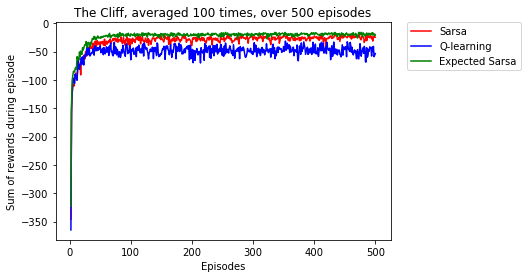

In [38]:
s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)
ex = ExpectedSarsa(environment, ALPHA, DISCOUNT, EPSILON)

sumOfRewardsPerEpisodeSarsa = s.averageMSumOfRewardsOverNEpisodes(100, 500)
sumOfRewardsPerEpisodeQLearning = ql.averageMSumOfRewardsOverNEpisodes(100, 500)
sumOfRewardsPerEpisodeExpectedSarsa = ex.averageMSumOfRewardsOverNEpisodes(100, 500)

plt.plot(np.arange(2, 501), sumOfRewardsPerEpisodeSarsa[1:500], 'r', label="Sarsa")
plt.plot(np.arange(2, 501), sumOfRewardsPerEpisodeQLearning[1:500], 'b', label="Q-learning")
plt.plot(np.arange(2, 501), sumOfRewardsPerEpisodeExpectedSarsa[1:500], 'g', label="Expected Sarsa")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('The Cliff, averaged 100 times, over 500 episodes')
plt.show()

*** To help visualisation, the sum of rewards of the first episode is not included in the graph***

Expected Sarsa peforms best, closely followed by Sarsa.

Let's take a look at each learned policy to see if there is any difference (randomness can affect results):

In [43]:
s.viewLearnedPolicy()

,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,


Sarsa takes the longer, safer path at the top of the gridworld, in case the ε-greedy policy throws it in the cliff.

In [41]:
ql.viewLearnedPolicy()

,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,


Q-learning just goes straight for the goal, taking the shorter but riskier path along the side of the cliff.

In [44]:
ex.viewLearnedPolicy()

,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,


Expected Sarsa takes a path a bit riskier than Sarsa but not as much as Q-learning. It is a good compromise between safety and performance, which would explain why it has the best results.

It is fun to see how these agent act much differently.

We could now try different epsilon values to see how this impacts results. To make visualisation/comparison easier, as in the book, results will be smoothed by averaging the reward sums from 10 successive episodes. Of course as well as averaging results 100 times.

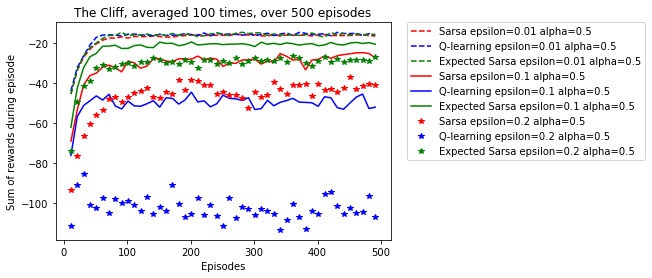

In [91]:
EPSILON = 0.01
s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)
ex = ExpectedSarsa(environment, ALPHA, DISCOUNT, EPSILON)

sumOfRewardsPerEpisodeSarsa1 = s.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)
sumOfRewardsPerEpisodeQLearning1 = ql.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)
sumOfRewardsPerEpisodeExpectedSarsa1 = ex.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)

EPSILON = 0.1
s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)
ex = ExpectedSarsa(environment, ALPHA, DISCOUNT, EPSILON)

sumOfRewardsPerEpisodeSarsa2 = s.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)
sumOfRewardsPerEpisodeQLearning2 = ql.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)
sumOfRewardsPerEpisodeExpectedSarsa2 = ex.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)

EPSILON = 0.2
s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)
ex = ExpectedSarsa(environment, ALPHA, DISCOUNT, EPSILON)

sumOfRewardsPerEpisodeSarsa3 = s.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)
sumOfRewardsPerEpisodeQLearning3 = ql.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)
sumOfRewardsPerEpisodeExpectedSarsa3 = ex.averageMSumOfRewardsSmoothedOverKEpisodesOverNEpisodes(100, 10, 500)

plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeSarsa1[1:50], 'r--', label="Sarsa epsilon=0.01 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeQLearning1[1:50], 'b--', label="Q-learning epsilon=0.01 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeExpectedSarsa1[1:50], 'g--', label="Expected Sarsa epsilon=0.01 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeSarsa2[1:50], 'r', label="Sarsa epsilon=0.1 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeQLearning2[1:50], 'b', label="Q-learning epsilon=0.1 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeExpectedSarsa2[1:50], 'g', label="Expected Sarsa epsilon=0.1 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeSarsa3[1:50], 'r*', label="Sarsa epsilon=0.2 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeQLearning3[1:50], 'b*', label="Q-learning epsilon=0.2 alpha=0.5")
plt.plot(np.arange(11, 501, 10), sumOfRewardsPerEpisodeExpectedSarsa3[1:50], 'g*', label="Expected Sarsa epsilon=0.2 alpha=0.5")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('The Cliff, averaged 100 times, over 500 episodes')
plt.show()

*** Again, to help visualisation, the sum of rewards of the first 10 episodes is not included in the graph.***

We see that at lower ε value, all algorithms perform pretty much the same. As the ε increases, the divergence in performance increases. With a higher ε value, Q-learning falls more often in the cliff, but when ε is low, is performs better as it falls less often. When ε is low, Sarsa must take less precautions and so results are similar for a lower ε.

## The Cliff and other environments

In a previous notebook, we had compared Sarsa and Q-learning on the Windy Gridworld environment and had observed that Q-learning performed better than Sarsa. Now in The Cliff environment, Sarsa performs better than Q-learning. Why is that? As is explained in the textbook [1], Q-learning learns values for the optimal policy, which brings it to travel along the edge of the cliff and occasionally falling off. Meanwhile, Sarsa takes the action selection into account and learns the safer path. As was the case in the Windy Gridworld, Q-learning would go straight for the goal, not taking risk into account, while Sarsa acted more safely. The impact of the risk is thus the factor affecting performance. In the Windy Gridworld, getting pushed by the wind was not too penalizing, but in the case of The Cliff, a negative reward of -100 makes a big difference. Let's see which algorithm performs best when we change the negative reward of -100 to -1, but still taking the agent back to the start when he falls.

In [10]:
class TheCliff2(TheCliff):
    def __init__(self):
        TheCliff.__init__(self)
        
    def takeAction(self, action):
        self.state += action
        
        if self.state[0] == 0 and 1 <= self.state[1] <= 10:
            self.state = [0, 0]
            return -1
        
        self.adjustStateIfOutsideGrid() # Agent is not allowed outside the grid

        if np.array_equal(self.state, self.GOAL):
            return 0
        else:
            return -1

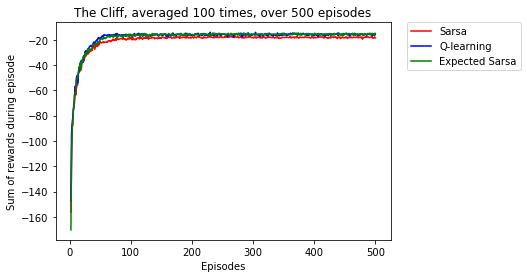

In [12]:
ALPHA = 0.5
EPSILON = 0.1
environment = TheCliff2()

s = Sarsa(environment, ALPHA, DISCOUNT, EPSILON)
ql = Qlearning(environment, ALPHA, DISCOUNT, EPSILON)
ex = ExpectedSarsa(environment, ALPHA, DISCOUNT, EPSILON)

sumOfRewardsPerEpisodeSarsa = s.averageMSumOfRewardsOverNEpisodes(100, 500)
sumOfRewardsPerEpisodeQLearning = ql.averageMSumOfRewardsOverNEpisodes(100, 500)
sumOfRewardsPerEpisodeExpectedSarsa = ex.averageMSumOfRewardsOverNEpisodes(100, 500)

plt.plot(np.arange(2, 501), sumOfRewardsPerEpisodeSarsa[1:500], 'r', label="Sarsa")
plt.plot(np.arange(2, 501), sumOfRewardsPerEpisodeQLearning[1:500], 'b', label="Q-learning")
plt.plot(np.arange(2, 501), sumOfRewardsPerEpisodeExpectedSarsa[1:500], 'g', label="Expected Sarsa")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('The Cliff, averaged 100 times, over 500 episodes')
plt.show()

*** To help visualisation, the sum of rewards of the first episode is not included in the graph***

Difference in performance varies less. Q-learning and Expected Sarsa did as well, Sarsa is underperforming slightly. This is not surprising, as Q-learning was heavily handicapped by the -100 reward when falling off the cliff.

## Conclusion

We've implemented and compared the Sarsa, Q-learning and Expected Sarsa algorithm on The Cliff environment found in the class textbook [1].

As we've seen, the value of the negative reward when falling off the cliff and the ε value is was affect results the most. When there is a strong negative reward, Q-learning does bad and Sarsa beats it. When the negative reward is not too punishing, Q-learning does better and can beat Sarsa. In all cases, Expected Sarsa does well and beats or is as good as the other algorithms.

It would be interesting to test these three algorithms on other environments, where risk is presented differently.

It would also be interesting to test Expected Sarsa on other environments, as it performed pretty well here.

## References

[1] <a href="https://webdocs.cs.ualberta.ca/~sutton/book/the-book-2nd.html">Richard S. Sutton and Andrew G. Barto, "Reinforcement learning: An introduction", Second Edition, MIT Press</a>, in preparation<br />
The Cliff example can be found on page 140.